# Tutor 1: Image classification with Convolutional Neural Networks (CNN)

## Introduction

Image classification is the task that associates each image with a proper class. The output is a vector of c elements where c is the number of classes of the specific task. Each element of the vector represents the probability that the input of the CNN belongs to the corresponding class. The highest value of the output vector indicates which is the class associated with the input. In the following image, there is an example taken from the EUROSAT Dataset to show a possible relationship between an image and a class.

## Install and imports

In [1]:
%pip install torchmetrics
# %pip install numpy==1.24.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 19.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
from sklearn.model_selection import StratifiedShuffleSplit
from PIL import Image
import random
from tqdm import tqdm


from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

import torch
from torch import nn

from torchsummary import summary
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T

from torchmetrics import Accuracy

## Dataset loading and splitting

The dataset used in this exercise is the EUROSAT (https://www.kaggle.com/datasets/apollo2506/eurosat-dataset). The dataset contains aerial images labeled with the 10 following classes:

* Annual Crop
* Forest
* Herbaceous Vegetation
* Highway
* Industrial
* Pasture
* Permanent Crop
* Residential
* River
* SeaLake


### Analisys and splitting of the dataset

In the following section, we will understand how to split the data in train, validation and test sets keeping a similar class distribution between the different sets.

1.   A list of all the file names and paths of the dataset will be obtained using the glob function.
2.   The list will be shuffled to properly split the dataset and divided into train, validation and test sets with a percentage of 0.7, 0.15, 0.15.
3. Three txt files will be created for train, validation and test respectively including the path of the files contained in the corresponding three sets.
4. The class distribution for each set will be shown

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

torchvision.datasets.EuroSAT(root="./", download=True)

100%|██████████| 94280567/94280567 [00:05<00:00, 17340215.46it/s]


Extracting ./eurosat/EuroSAT.zip to ./eurosat


Dataset EuroSAT
    Number of datapoints: 27000
    Root location: ./

['SeaLake', 'HerbaceousVegetation', 'Industrial', 'River', 'Highway', 'Residential', 'PermanentCrop', 'Pasture', 'Forest', 'AnnualCrop']


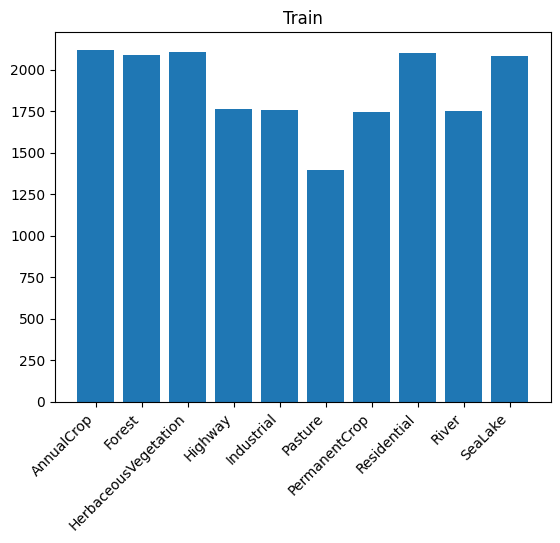

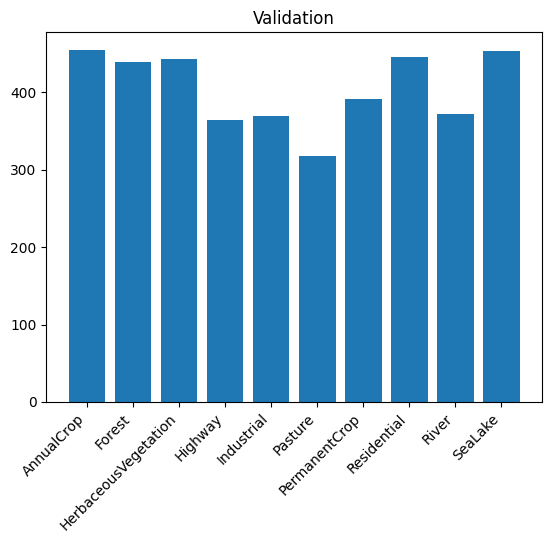

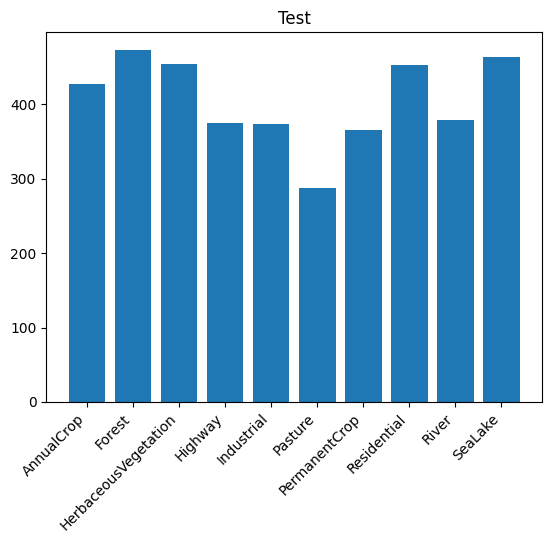

In [4]:
def create_txt(path, name_list):
  file = open(path, 'w')
  for item in name_list:
    file.write(item + "\n")
  file.close()

def plot_distribution(data, mode='train'):
  # Plot distribution train and test
  names = list(data.keys())
  values = list(data.values())

  plt.bar(range(len(data)), values, tick_label=names)
  plt.title(mode)
  plt.xticks(rotation=45, ha="right")
  plt.show()

# Function to show the distribution of classes after the splitting of the dataset
def show_distribution(files, mode='Train'):
  labels = []
  for f in files:
    labels.append(f.split('/')[0])

  labels_count = Counter(labels)
  stats = OrderedDict(sorted(labels_count.items()))

  plot_distribution(stats, mode=mode)

random.seed(123)

dataset_path = './eurosat/2750'

labels_list = os.listdir(dataset_path)
print(labels_list)

image_filenames = ['/'.join(x.replace("\\", "/").split("/")[-2:]) for x in glob.glob(join(dataset_path , '*/*.*')) if x.endswith("jpg")]
# print(image_filenames)
random.shuffle(image_filenames)

perc = 0.7
train_files = image_filenames[:int(np.round(len(image_filenames)*perc))]
val_files = image_filenames[int(np.round(len(image_filenames)*perc)):int(np.round(len(image_filenames)*perc)+np.round(len(image_filenames)*((1-perc)/2)))]
test_files = image_filenames[int(np.round(len(image_filenames)*perc)+np.round(len(image_filenames)*((1-perc)/2))):]

# Create train and test
create_txt(join(dataset_path, 'train_list.txt'), train_files)
create_txt(join(dataset_path, 'val_list.txt'), val_files)
create_txt(join(dataset_path, 'test_list.txt'), test_files)

# Show label distributions
show_distribution(train_files, mode='Train')
show_distribution(val_files, mode='Validation')
show_distribution(test_files, mode='Test')


## Dataset Class

Definition of a custom dataset class in pytorch that is used to create the different train, validation and test sets, defining how we will access the data and create the batches during training. To create a custom dataset in pytorch it is necessary to create a new class which __inherits the class Dataset__ from torch.utils.data. Then it is necessary to create at least __3 functions__:

1.   __\_\_init____: to establish the attributes of the dataset. In this case, we will use the following information:
  - path of the folder that contains the path of our image files
  - list of names of our labels
  - transformation applied to each image to become inputs of the network (also used for the data augmentation)

2.   __\_\_getitem____: the function that accesses and returns the couple of image and label elements after the application of the data augmentation

3. __\_\_len____: it returns the length of our set



In [5]:
class EuroSAT_dataset(data.Dataset):
    def __init__(self, root_path, name_list, transforms=None):
        super().__init__()

        # create an attribute that includes the path of all the images of the dataset, including the name of the files
        self.root_path = root_path
        self.image_filenames = open(join(root_path, name_list)).read().split('\n')[:-1]

        # create an attribute that includes the list of labels
        self.labels_list = [x for x in os.listdir(root_path) if os.path.isdir(join(root_path, x))] # labels name
        self.transforms = transforms

    def __getitem__(self, index):
        ######################
        # YOUR CODE HERE

        # Open the input image and get the corresponent target index using the image path and the labels_list
        input = Image.open(join(self.root_path, self.image_filenames[index]))
        target = torch.tensor(self.labels_list.index(self.image_filenames[index].split('/')[0]), dtype=torch.long)


        ######################
        # YOUR CODE HERE

        # Apply the transformations on the input
        if self.transforms is not None:
            input = self.transforms(input)

        return input, target

    def __len__(self):
        return len(self.image_filenames)

## Network

Typically, a convolutional neural network for classification can be divided into two parts:

1.   Convolutional part that takes in input the image and extracts feature maps at each layer optimizing the weights of the convolution.
2.   A fully connected part that directly follows the convolutional part. The input is the flattened version of the features extracted from the first part. The output is the vector that represents the probability of the input to belong to a class.



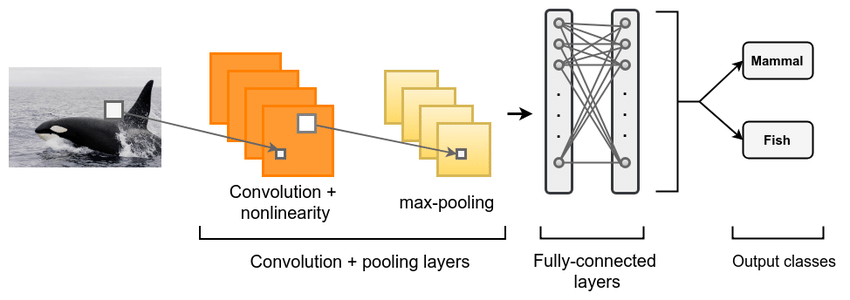

Example of CNN for Image Classification (image from Accelerometer-Based Human Fall Detection Using Convolutional Neural Networks - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Example-of-a-CNN-for-image-classification_fig1_332284670)

In [6]:
class ConvNet(nn.Module):
  def __init__(self, in_channels, n_classes, drop_p=0.2):
    super().__init__()

    ######################
    # YOUR CODE HERE

    # Convolutional layers
    # This part of the network will be composed of 4 blocks with similar structure:
      # a 2D convolutional layer
      # a ReLU activation function
      # a MaxPooling
      # a Dropout

    # First block
    # the 2D convolutional layer will have out_channels=32, kernel_size=5, no padding and stride=1
    # MaxPooling with kernel_size=2
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5, padding=0, stride=1) # (3, 224, 224) --> (32, 220, 220)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2) # (32, 224, 224) --> (32, 110, 110)
    self.drop1 = nn.Dropout(p=drop_p)

    # Second block
    # the 2D convolutional layer will have out_channels=64, kernel_size=3, no padding and stride=1
    # MaxPooling with kernel_size=2
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1) # (32, 110, 110) --> (64, 108, 108)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2) # (64, 108, 108) --> (64, 54, 54)
    self.drop2 = nn.Dropout(p=drop_p)

    # Third block
    # the 2D convolutional layer will have out_channels=16, kernel_size=3, no padding and stride=1
    # MaxPooling with kernel_size=2
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, padding=0, stride=1) # (64, 54, 54) --> (16, 52, 52)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2) # (16, 52, 52) --> (16, 26, 26)
    self.drop3 = nn.Dropout(p=drop_p)

    # Fourth block
    # the 2D convolutional layer will have out_channels=8, kernel_size=3, no padding and stride=1
    # MaxPooling with kernel_size=2
    self.conv4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=0, stride=1) # (16, 26, 26) --> (8, 24, 24)
    self.relu4 = nn.ReLU()
    self.pool4 = nn.MaxPool2d(kernel_size=2) # (8, 24, 24) --> (8, 12, 12)
    self.drop4 = nn.Dropout(p=drop_p)

    ######################
    # YOUR CODE HERE

    # Fully Connected layers
    # This part of the network will consist of 3 blocks:
    # a Fully Connected layer
    # a ReLU activation function
    # a Dropout

    # First Block
    # the fully connected layer will have an in_features equal to the product of the dimensions
    #  of the output of the last concolutional block and out_features=512
    self.fc1 = nn.Linear(in_features=1152, out_features=512) # in_features = 8 * 12 * 12
    self.relu_fc1 = nn.ReLU()
    self.drop_fc1 = nn.Dropout(p=drop_p)

    # Second Block
    # the fully connected layer will have out_features=128
    self.fc2 = nn.Linear(in_features=512, out_features=128)
    self.relu_fc2 = nn.ReLU()
    self.drop_fc2 = nn.Dropout(p=drop_p)

    # Third Block
    # the fully connected layer will have out_features=32
    self.fc3 = nn.Linear(in_features=128, out_features=32)
    self.relu_fc3 = nn.ReLU()
    self.drop_fc3 = nn.Dropout(p=drop_p)

    # Prediction layer
    self.out = nn.Linear(in_features=32, out_features=n_classes)


  def forward(self, x):
    # Convolutions
    x = self.drop1(self.pool1(self.relu1(self.conv1(x))))
    x = self.drop2(self.pool2(self.relu2(self.conv2(x))))
    x = self.drop3(self.pool3(self.relu3(self.conv3(x))))
    x = self.drop4(self.pool4(self.relu4(self.conv4(x))))

    # Flatten and fully connected
    x = x.flatten(1) # from dimension 1

    x = self.drop_fc1(self.relu_fc1(self.fc1(x)))
    x = self.drop_fc2(self.relu_fc2(self.fc2(x)))
    x = self.drop_fc3(self.relu_fc3(self.fc3(x)))

    x = self.out(x)

    return x


## Training and Validation loop

In [7]:
def train(net, train_loader, val_loader, conf_train):

    device = conf_train['device']
    epochs = conf_train['epochs']
    loss_function = conf_train['loss_function'].to(device)
    train_metric_function = conf_train['metric_function'].to(device)
    val_metric_function = train_metric_function.clone()
    optimizer = conf_train['optimizer']

    net.to(device)

    # Needed Variables
    epochs_train_losses = []
    epochs_val_losses = []

    epochs_train_metrics = []
    epochs_val_metrics = []
    max_val_metrics = 0.

    with tqdm(range(epochs)) as progress:
      for epoch in progress:
        # train epoch
        batch_train_losses = []
        batch_val_losses = []

        net.train()
        for i, batch in enumerate(train_loader):
          im, gt = batch

          im = im.to(device)
          gt = gt.to(device)

          ######################
          # YOUR CODE HERE
          # get the prediction from the model
          pred = net(im)

          ######################
          # YOUR CODE HERE
          # compute train loss
          loss = loss_function(pred, gt)

          # compute train accuracy
          train_metric_function.update(pred, gt)

          ######################
          # YOUR CODE HERE
          # Apply all the steps for the update of the weights
          # reset the grads
          # compute the backward
          # apply the step
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          batch_train_losses.append(loss.detach().to('cpu'))

        epochs_train_losses.append(np.mean(batch_train_losses))
        epochs_train_metrics.append(train_metric_function.compute().to('cpu'))

        # reset the metric function
        train_metric_function.reset()

        # Validation loop
        net.eval()
        with torch.no_grad():
          for i, batch in enumerate(val_loader):
            im, gt = batch

            im = im.to(device)
            gt = gt.to(device)

            ######################
            # YOUR CODE HERE
            # get the prediction from the model
            pred = net(im)

            ######################
            # YOUR CODE HERE
            # compute val loss
            loss = loss_function(pred, gt)
            batch_val_losses.append(loss.detach().to('cpu'))

            # compute validation metrics
            val_metric_function.update(pred, gt)

          current_val_metric = val_metric_function.compute()

          epochs_val_losses.append(np.mean(batch_val_losses))
          epochs_val_metrics.append(current_val_metric.to('cpu'))
          val_metric_function.reset()

        progress.set_postfix({'train_loss': np.round(epochs_train_losses[-1],2),
                              'train_acc': np.round(epochs_train_metrics[-1].item(),2),
                              'validation_loss': np.round(epochs_val_losses[-1],2),
                              'validation_acc': np.round(epochs_val_metrics[-1].item(),2),})

        if epochs_val_metrics[-1] > max_val_metrics:
          # save the model
          torch.save(net.state_dict(), 'best-model.pt')

          # sub max_val_metric
          max_val_metrics = epochs_val_metrics[-1]

    losses = {
              'train_losses' : epochs_train_losses,
              'val_losses': epochs_val_losses,
              }

    metrics = {
          'train_metrics' : epochs_train_metrics,
          'val_metrics': epochs_val_metrics,
          }


    return net, losses, metrics

## Test loop

In [8]:
def test(net, test_loader, conf_test):
  device = conf_test['device']
  metric_function = conf_test['metric_function'].to(device)
  net.to(device)

  ######################
  # YOUR CODE HERE

  # Define the test loop returning the metrics

  net.eval()
  with torch.no_grad():
    for i, batch in enumerate(test_loader):
      im, gt = batch

      im = im.to(device)
      gt = gt.to(device)

      pred = net(im)

      # compute metrics
      metric_function.update(pred, gt)

    metric = metric_function.compute()
    metric_function.reset()

  return metric


## Train of the network

### Initialization of the train, validation and test sets and dataloaders

The Dataset class defined before is used to create the train, validation and test set. After the initialization of each set a dataloader is initialized. The dataloader handle the loading of the batches during the training using the \_\_get_item__ function defined in the Dataset class to access the single elements.

In [9]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Dataset parameters
root_path = './eurosat/2750'
train_path = 'train_list.txt'
val_path = 'val_list.txt'
test_path = 'test_list.txt'

im_size=224
num_classes = 10

# Dataloader parameters

batch_size = 32
num_workers = 2

cuda


In [10]:
train_transforms = T.Compose([
    T.Resize(im_size),
    T.ToTensor(),
    ])

val_transforms = T.Compose([
    T.Resize(im_size),
    T.ToTensor(),
    ])

train_set = EuroSAT_dataset(root_path=root_path, name_list=train_path, transforms=train_transforms)
val_set = EuroSAT_dataset(root_path=root_path, name_list=val_path, transforms=val_transforms)
test_set = EuroSAT_dataset(root_path=root_path, name_list=test_path, transforms=val_transforms)

train_loader = data.DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True, drop_last=True) # drop last True --> drop the last bacth if it smaller than the chosen batch size
val_loader = data.DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)

torch.Size([32, 3, 224, 224])
torch.Size([32])


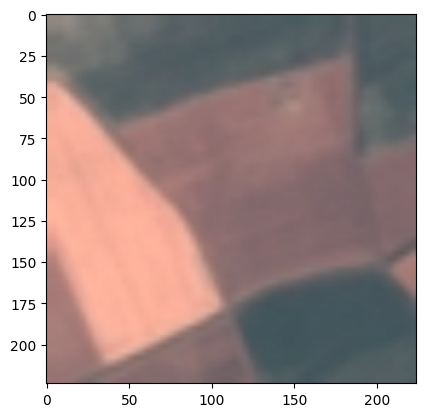

Label of image 0: 9


In [11]:
batch_sample = next(iter(train_loader))
images, labels = batch_sample

print(images.shape)
print(labels.shape)

index = 0
plt.imshow(images[index].transpose(0,2).cpu().detach().numpy())
plt.show()
print('Label of image ' + str(index) + ': ' + str(labels[index].item()))


### Setting of training parameters

In [12]:
# Network parameters
in_channels = 3
n_classes = 10
dropout = 0.2

# Training parameter
epochs = 50
lr = 1e-4

### Neural Network initialization

In [13]:
model = ConvNet(in_channels=in_channels, n_classes=n_classes, drop_p=dropout)

summary(model.to(device), (in_channels, im_size, im_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           2,432
              ReLU-2         [-1, 32, 220, 220]               0
         MaxPool2d-3         [-1, 32, 110, 110]               0
           Dropout-4         [-1, 32, 110, 110]               0
            Conv2d-5         [-1, 64, 108, 108]          18,496
              ReLU-6         [-1, 64, 108, 108]               0
         MaxPool2d-7           [-1, 64, 54, 54]               0
           Dropout-8           [-1, 64, 54, 54]               0
            Conv2d-9           [-1, 16, 52, 52]           9,232
             ReLU-10           [-1, 16, 52, 52]               0
        MaxPool2d-11           [-1, 16, 26, 26]               0
          Dropout-12           [-1, 16, 26, 26]               0
           Conv2d-13            [-1, 8, 24, 24]           1,160
             ReLU-14            [-1, 8,

Setting of loss function, optimizer and evaluation metric

In [14]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Evaluation function
metric_function = Accuracy(task='multiclass', num_classes=num_classes, average='macro') # average='macro' --> Compute the average of the accuracy on each class

conf_train = {
              'epochs' : epochs,
              'loss_function' : loss_function,
              'optimizer' : optimizer,
              'metric_function' : metric_function,
              'device' : device,
              }

### Exectution of the training

In [15]:
trained_model, losses, metrics = train(model, train_loader, val_loader, conf_train)

100%|██████████| 50/50 [48:44<00:00, 58.48s/it, train_loss=0.48, train_acc=0.83, validation_loss=0.58, validation_acc=0.8]


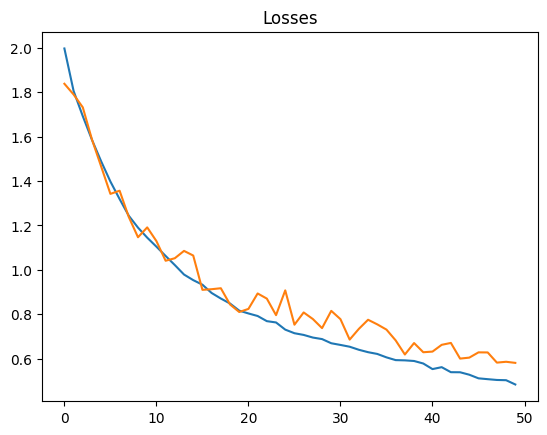

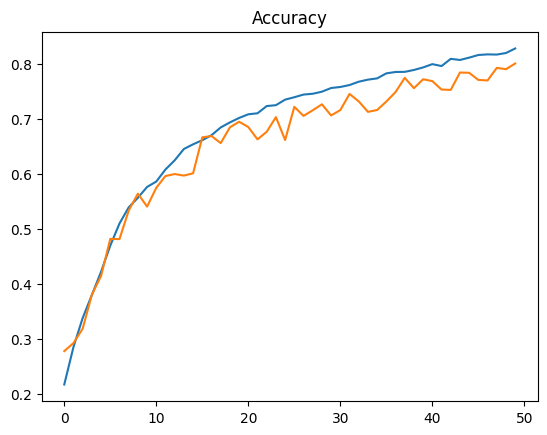

In [16]:
plt.plot(range(epochs), losses['train_losses'])
plt.title('Losses')
plt.plot(range(epochs), losses['val_losses'])
plt.show()

plt.plot(range(epochs), metrics['train_metrics'])
plt.title('Accuracy')
plt.plot(range(epochs), metrics['val_metrics'])
plt.show()

### Test evaluation

In [17]:
best_model = ConvNet(in_channels=in_channels, n_classes=n_classes, drop_p=dropout)
best_model.load_state_dict(torch.load('best-model.pt'))

test_metrics = test(best_model, test_loader, conf_train)
print('The overall accuracy on the test set is: ' + str(test_metrics.item()))

<ipython-input-17-61756da8ece2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best-model.pt'))


The overall accuracy on the test set is: 0.7918788194656372
